In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.227038  0.018397  0.427022  1.702170 -0.644350 -0.273528 -1.228898   
  1  -0.245785 -0.721451  1.199790 -0.233723 -0.688459 -0.388513 -0.082397   
  2   0.104695 -0.421002  0.626519  0.328438  1.281229  1.007100  0.332324   
  3  -0.753677 -0.228257 -0.047427  0.170810 -1.298096 -0.558064  0.588680   
  4   0.636014 -0.291255  0.361866 -1.008309 -0.315554  0.990392 -0.358246   
  5   0.904312  0.285439 -0.324969 -0.017232 -0.067445  0.435009  0.360777   
  6   0.145894 -0.309437 -0.107132 -0.689116 -0.759238 -0.073723 -0.760831   
  7  -0.819753 -0.284109 -0.053450  0.410163  0.601997  0.541040 -0.928820   
  8   0.051269 -0.101940 -0.216231  0.596344 -0.136911  0.209415  0.044197   
  9   0.906766  1.393323 -0.008421  0.812070  0.294110 -0.459507 -0.910315   
  10  0.218119 -0.410969 -0.041715  0.258624  1.237220  1.183435  0.232168   
  11  0.208158  0.152158  0.319797  0.314844 -0.368616  0.274442  0.249822   
  12 -0.448858 -0.114821 -0.398395 -0.321792  0.210805  0.002278  0.563765   
  13  0.526751  0.697411 -1.154934 -0.508835  0.048250  1.035769  1.348313   
  14  0.565563  0.510171  1.048969  0.872298  0.236377  1.116606 -0.138111   
  15  0.171335 -0.548665  0.294206  0.370008 -0.494637  0.683118  0.231763   
  16 -0.193687  0.543008  0.800689 -0.718090 -0.946449 -0.064329  0.316970   
  17 -0.784374 -0.648566 -0.248696 -0.545308  0.468791  0.534353  0.435954   
  18 -0.004959  0.133050  0.563677  0.094844 -0.395261  1.418394  0.270021   
  19 -0.132114 -1.356251 -0.526840  0.386306  0.223886 -0.196051 -0.186895   
  20 -0.579233 -0.385879  0.407022  1.065905 -0.435010 -0.574925  0.174804   
  21  0.084075 -0.493606  0.245849  0.945366 -0.045102  0.735050 -1.732859   
  22 -0.640224 -0.517723 -0.680560 -0.150408 -0.178444 -0.361004  0.156847   
  23 -0.052452  0.314361  0.968855  0.445312 -0.693101 -0.617388 -0.330795   
  24  0.125273 -0.496569  0.345915 -0.566126 -0.613786  0.365661 -0.032098   
1 0   0.058133  0.170044  0.149469  1.649708 -0.194434  0.950921  0.223117   
  1  -0.638400  0.084896 -0.503605 -0.048770  0.037185 -0.675014 -0.107792   
  2   1.063514  0.680553  0.518968  0.526581 -1.501559 -0.030157  0.804129   
  3  -0.370077 -1.340475 -0.943032 -0.010511  0.104846  1.785073  0.943556   
  4   1.575158  0.677865  0.481035  0.734805  0.112087 -0.415648 -0.435995   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   1.167064  0.160048  0.465876  ... -0.335770 -1.032230  0.457034   
  1  -0.052453 -1.143071 -0.739034  ... -1.361264 -1.295549  0.753513   
  2   1.501486  0.900063  0.185004  ... -0.131680  0.418662  1.468809   
  3   1.421473  0.705316 -0.188037  ...  1.041978  0.922146 -0.078086   
  4   0.484954 -0.205603 -0.516612  ... -0.352506 -0.205193  0.739534   
  5   0.038603 -0.863468 -0.622227  ...  0.589519  0.659681  1.045540   
  6   0.946614 -0.162753 -0.444685  ... -1.733443  0.031211  0.213017   
  7   0.707266 -0.404001 -0.674717  ... -0.439031  0.120608 -0.219449   
  8   0.142217 -0.146077  0.517832  ... -0.303140  0.180839  0.334928   
  9   0.489631 -0.159002  0.511227  ...  0.096796  0.007516  0.747499   
  10 -0.290310 -0.465608 -0.468012  ... -1.056162  0.229212 -0.847141   
  11 -0.009943 -0.904694 -0.630213  ... -0.450810  0.357160  0.913339   
  12  0.592620 -0.856458 -0.465190  ... -0.195328  0.239539  0.195849   
  13  0.790370  0.621703  0.174755  ... -0.215333  0.110864  0.015395   
  14  0.199839 -0.094352 -0.750767  ...  0.154626  0.470233 -0.261343   
  15  0.785996 -0.707136 -0.833343  ... -0.603704  0.281034  0.732372   
  16  0.959251  0.372449  0.211954  ... -0.187276  1.172075  0.153036   
  17  0.934168 -0.602083 -0.550731  ... -0.635396 -0.237784  0.153797   
  18  0.010327  0.301511  1.060806  ... -0.476211  0.573278 -0.243208   
  19  0.588818 -0.659396  0.223687  ... -0.667185  0.086084  0.428339   
  20 -0.035994 -0.625155 -0.264765  ...  0.428252 -0.182066 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err         t          P>|t|     2.5 %    97.5 %
D  1.134172  0.041314  27.45236  6.511290e-166  1.053198  1.215146


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



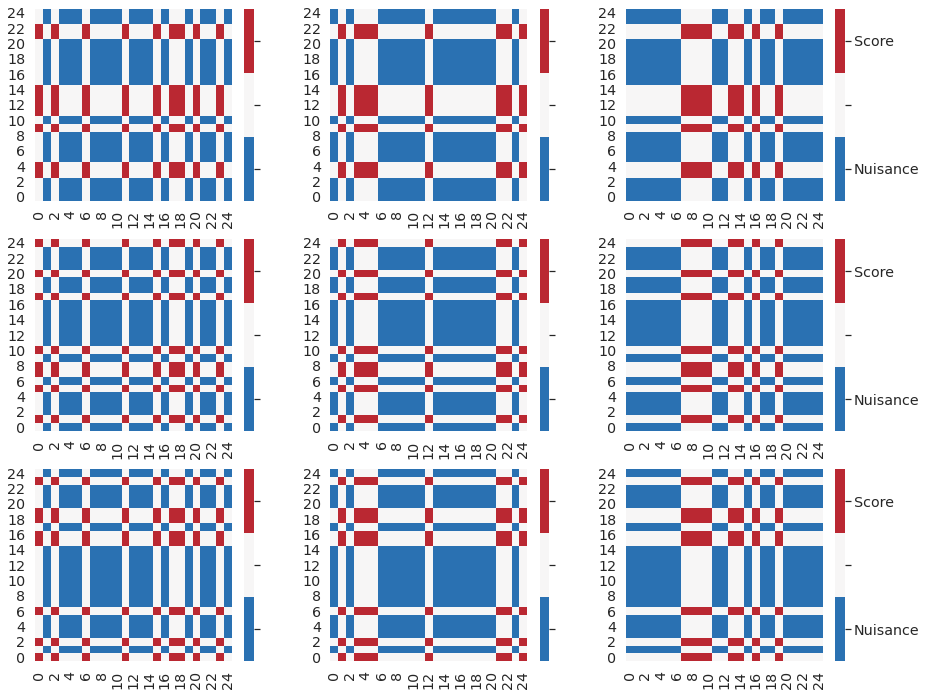

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



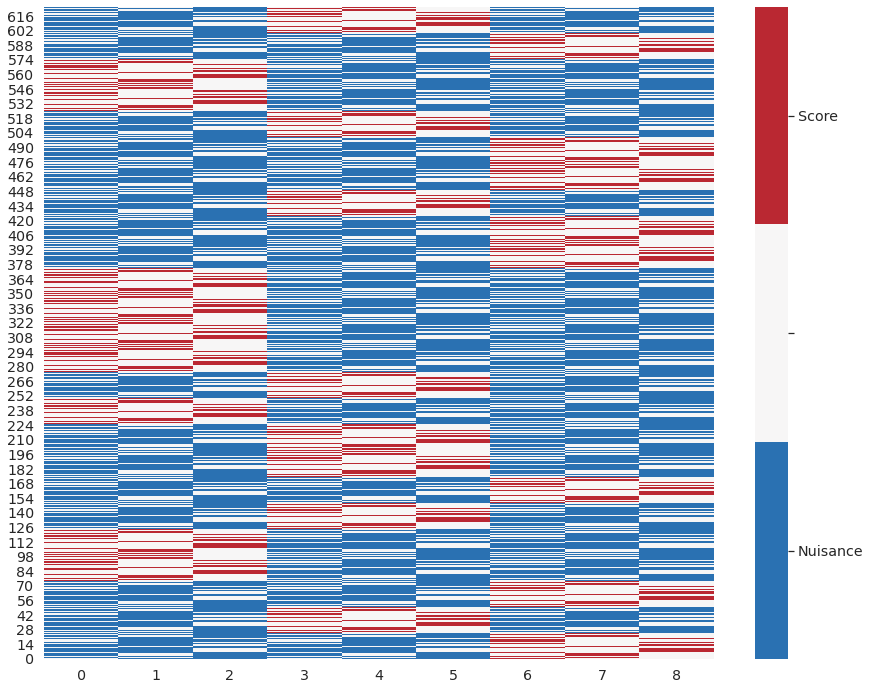

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])